In [2]:
# Numpy to make life easy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt

# Increase default font size
plt.rcParams.update({'font.size': 14})

# Import for progress meter
from tqdm import tqdm, trange

!pip install numba

from numba import jit

## Problem 1.)
  

In [3]:
#This code allows for a simple test of the first part of problem 1. 
def check_prob_1_a(N, x, dx, mu):
    p=mu*dx    #This is the actual equation, however it gives an array.
    p=0.1      #A solution is to simply define p with the value 0.1
    xs = 0
    while(np.random.rand() > p):
        xs+=dx
        if (xs >= x[-1]):
            return True
    return False

N = 1000
x, dx = np.linspace(0, 10, N+1, retstep = True) #Designing the x-axis and step size
mu = np.ones(len(x))*0.1        #Setting the attenuation coefficient as an array
                                #instead of creating two different equations or 
                                #using isinstance(), so that @jit can be used.
n_ph = 10000   #Setting the number of photons we send towards the material.


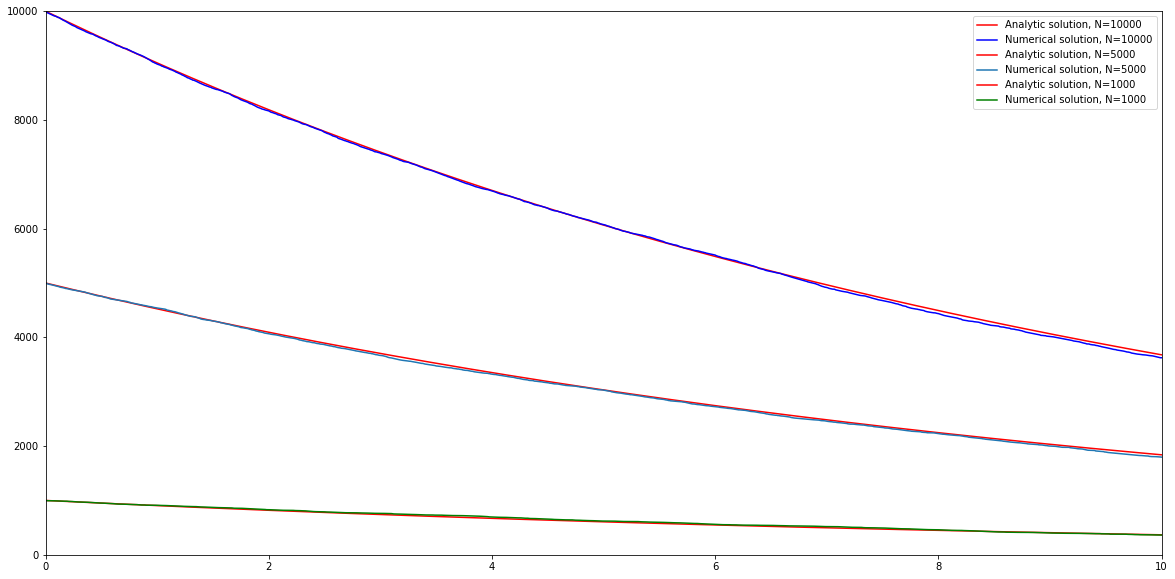

In [4]:
#A more general approach that can be reused.
#the calculation subracts 1 if the photon is stopped in the material. 
#Finally plotting this up against the analytic solution. 
N=1000
n_ph=10000
@jit(nopython = True)
def mainCode(x, dx, mu, n_ph):       #Main function
    p = mu*dx                        
    ph_pos = n_ph + 0*x
    for i in range(n_ph):
        for j in range(len(ph_pos)):
            test = np.random.rand() < p[j]
            if test:
                ph_pos[j:] -=1       #Removing photon if absorbed
                break
    return ph_pos


n_ph2 = n_ph-5000
n_ph3 = n_ph-9000
ph_pos1 = mainCode(x, dx, mu, n_ph)
ph_pos2 = mainCode(x, dx, mu, n_ph2)
ph_pos3 = mainCode(x, dx, mu, n_ph3)


#Plotting numerical vs analytic
plt.figure(0, figsize=(20,10))
plt.plot(x, n_ph*np.exp(-mu*x), "r", label = "Analytic solution, N=10000")
plt.plot(x, ph_pos1, "b", label = "Numerical solution, N=10000")
plt.plot(x, n_ph2*np.exp(-mu*x), "r", label = "Analytic solution, N=5000")
plt.plot(x, ph_pos2, label = "Numerical solution, N=5000")
plt.plot(x, n_ph3*np.exp(-mu*x), "r", label = "Analytic solution, N=1000")
plt.plot(x, ph_pos3, "g", label = "Numerical solution, N=1000")

plt.axis([0, 10, 0, n_ph])
plt.legend()
plt.show()
#print(ph_pos[-1])


The photon does not always reach the end. It depends on the probability for transmission, which is not always one so the possibility of scattering exists. 

From analyzing the curve we can determine that approximately 40% of photons pass.
The number printed below the plot represents photons that have passed through and reached the detector. Roughly 2 in 5 times a photon passes the 10 centimeter thick material. 

Since the probability relies heavily on mu, we need to make sure that it does not exceed 1. Then the plot would tell us that the material absorbs everything at the very beginning. 

A high number of photons gives a continuos graph similiar to the analytic function. We plot the remaining photons so a small amount would mean a graph with obvious steps. 

A larger stepsize would also mean a higher probability for scattering, resulting in a smaller number of photons that reach the detector. 

## Problem 2.)

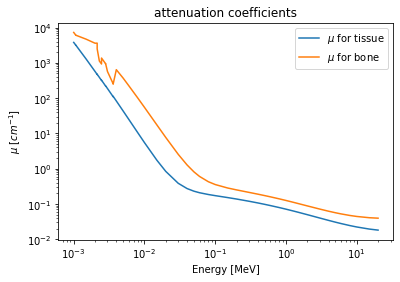

In [5]:
#Information from textfiles
rhoTissue = 1.02     #[g cm^-3]
rhoBone = 1.92       #[g cm^-3]
L = 3                #[cm]

muTissueEv =  np.loadtxt("data/tissue.txt",dtype = "float", delimiter = ",", usecols = 0)
muTissue = rhoTissue*np.loadtxt("data/tissue.txt",dtype = "float", delimiter = ",", usecols = 1)
muBoneEv = np.loadtxt("data/tissue.txt",dtype = "float", delimiter = ",", usecols = 0)
muBone = rhoBone*np.loadtxt("data/bone.txt",dtype = "float", delimiter = ",", usecols = 1)

plt.figure(1)
plt.title("attenuation coefficients")
plt.plot(muTissueEv, muTissue, label = "$\mu$ for tissue")
plt.plot(muBoneEv, muBone, label = "$\mu$ for bone")
plt.xlabel("Energy [MeV]")
plt.ylabel("$\mu$ [$cm^{-1}]$")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

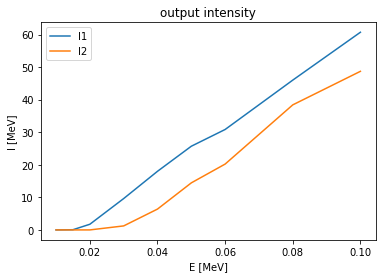

C:\Users\augus\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


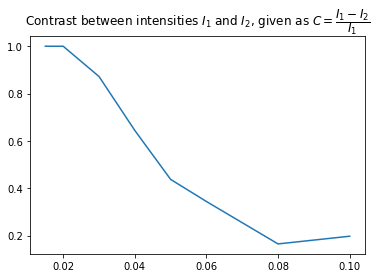

In [6]:
#Defining a subarray of muTissueEv with the energylevels needed in this project.
energyLevels=muTissueEv[21:30]

N = 999

x, dx = np.linspace(0, 3, N, retstep = True)

I1 = np.zeros(len(energyLevels))         #defining two arrays of intensity, one for 3cm of tissue and one for 
I2 = np.zeros(len(energyLevels))         #1cm of tissue then 1cm of bone then 1cm of tissue. 

muI2 = np.zeros(shape = (len(energyLevels), N))        #Replacing the middle third of the array with mu-values corresponding to bone. 
for k in range(len(energyLevels)):
    muI2[k] += muTissue[k+21]
    muI2[k][int(N/3):int(N*2/3)] = muBone[k+21]

@jit(nopython = True)
def intensities(n_ph,k):                #Filling the intensity arrays I1 and I2 with the correct values.
    I2 = (mainCode(x, dx, muI2[k], n_ph)[-1]) * muBoneEv[k+21]
    I1 = (mainCode(x, dx, np.ones(len(x))*muTissue[k+21], n_ph)[-1]) * energyLevels[k]
    return I1, I2

I2 = np.zeros(len(energyLevels))
I1 = np.zeros(len(energyLevels))
for k in range(len(energyLevels)):
    I1[k], I2[k] = intensities(1000,k)    #Setting the values by iterating all energies from 10 to 100keV

plt.figure(2)
plt.title("output intensity")
plt.plot(energyLevels, I1, label = "I1")
plt.plot(energyLevels, I2, label = "I2")
plt.legend()
plt.ylabel("I [MeV]")
plt.xlabel("E [MeV]")
plt.show()

plt.figure(3)
C = ((I1-I2)/I1)
plt.title("Contrast between intensities $I_1$ and $I_2$, given as $C = \dfrac{I_1-I_2}{I_1}$")
plt.plot(energyLevels, C)
plt.show()

In [7]:
%%time

@jit(nopython = True)
#Code for the minimum number of photons required for the detector to detect a signal
def neededPhotons():
    needed_ph=np.zeros(len(energyLevels))
    I_tissue=np.zeros(len(energyLevels))
    I_bone=np.zeros(len(energyLevels))                                  
    for i in range(len(energyLevels)):
        incr = 10 + (len(energyLevels)-i)*10
        n_ph = 100 #number of photons
        intensity, intensityb = intensities(n_ph, i)       #Intensity from previous task
        while (intensity < 10) and (n_ph<10**6):           #Because of runtime, and repeated tests
                                                           #We are certain that the values are not 
                                                           #affected, even though we increase the
                                                           #incrementation values dramatically,
            n_ph += incr                                               
            intensity, intensityb = intensities(n_ph,i)
            
            if n_ph>10**5:
                n_ph+=10000                                #Runtime 2,5min, får vi den lavere med like høy/høyere n_ph?
            elif n_ph>10000:
                n_ph+=10000
        I_tissue[i]= intensity
        I_bone[i] = intensityb
        needed_ph[i]=n_ph
    return needed_ph, I_tissue, I_bone
needed_Ph, ITissue, IBone = neededPhotons()
print(needed_Ph)
print(ITissue)

[1.0099e+06 1.4117e+05 6.2600e+03 1.1500e+03 5.8000e+02 4.0000e+02
 3.4000e+02 2.2000e+02 1.6000e+02]
[ 0.    11.025 10.26  10.29  11.72  10.2   10.38  10.24  10.7  ]
Wall time: 2min 29s


In [18]:
@jit(nopython = True)
#Code for the dosage with the lowest required number of photons
def dosage(rhoTissue, rhoBone, L, A, needed_Ph):
    dose = energyLevels * 0 
    absorbedPhBone = np.zeros(shape = (len(energyLevels), N))
    absorbedPhTissue = np.zeros(shape = (len(energyLevels), N))
    for k in range(len(energyLevels)):
        absorbedPhTissue[k] = needed_Ph[k] - mainCode(x, dx, np.ones(N)*muTissue[21+k], needed_Ph[k])
        absorbedPhBone[k] = needed_Ph[k] - mainCode(x, dx, muI2[k], needed_Ph[k])

        #Need to take in to account the changing number of photons in the matter, as well as 
        #density differences between tissue and bone. Split up the arrays in three parts,
        #tissue, bone, tissue, all 1 cm thick.  
        
        for i in range(N+1):
            if (i > int(N/3)) and (i < int(N*2/3)):
                dose[k]+=((absorbedPhTissue[k][i]/rhoTissue) + (absorbedPhBone[k][i]/rhoBone))*energyLevels[k]/(L*A)
            else:
                dose[k]+=((absorbedPhTissue[k][i]+absorbedPhBone[k][i])*energyLevels[k])/(rhoTissue*L*A)
    return dose
dose = dosage(rhoTissue, rhoBone, 3, 1, needed_Ph)

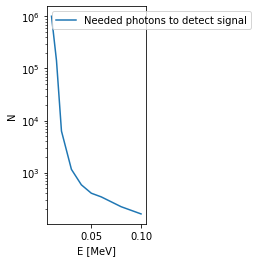

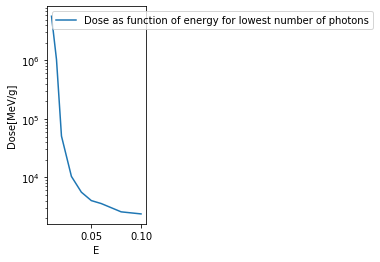

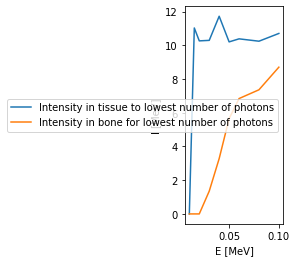

In [19]:
# plt.figure(4, figsize=(4, 4))
# plt.plot(energyLevels, needed_Ph, label="Needed photons to detect signal")
# plt.yscale("log")
# plt.ylabel("N")
# plt.xlabel("E [MeV]")
# plt.legend()
# plt.show()

plt.subplot(1, 3, 1)
plt.plot(energyLevels, needed_Ph, label="Needed photons to detect signal")
plt.yscale("log")
plt.ylabel("N")
plt.xlabel("E [MeV]")
plt.legend()
plt.show()

plt.subplot(1, 3, 2)
plt.plot(energyLevels, dose, label="Dose as function of energy for lowest number of photons")
plt.yscale("log")
plt.ylabel("Dose[MeV/g]")
plt.xlabel("E")
plt.legend()
plt.show()

# plt.figure(5, figsize=(4, 4))
# plt.plot(energyLevels, dose/10**3, label="Dose as function of energy for lowest number of photons")
# plt.yscale("log")
# plt.ylabel("Dose[MeV/g]")
# plt.xlabel("E")
# plt.legend()
# plt.show()
plt.subplot(1,3,3)
#plt.figure(6, figsize=(4, 4))                  
plt.plot(energyLevels, ITissue, label="Intensity in tissue to lowest number of photons")
plt.plot(energyLevels, IBone, label="Intensity in bone for lowest number of photons")
plt.ylabel("I [MeV]")
plt.xlabel("E [MeV]")
plt.legend()
plt.show()

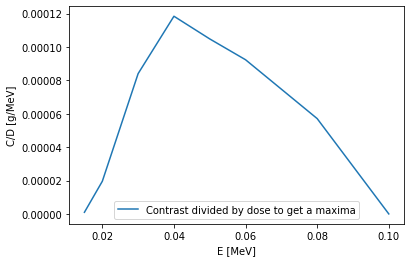

In [12]:
#By plotting contrast divided by dose, we find that there exist a maxima in which the contrast
#value is at a high value and the dosage low.
plt.figure(7)
plt.plot(energyLevels, C/dose, label="Contrast divided by dose to get a maxima")
plt.xlabel("E [MeV]")
plt.ylabel("C/D [g/MeV]")
plt.legend()
plt.show()

Her skal grafene over diskuteres


## Task 3
When mapping a 3D-object with attenuation coefficients, the Monte-Carlo method is arguably not the most efficient way of proceeding. In task 1, the task was to plot the remaining pohotons at each step. This task however, is only to know how many photons that make it to the end. Therefore, one could argue that it is a waste of processing power to simulate the amount of photons at every step with the Monte-Carlo method. Considering this, we chose to solve the problem using the law of total probability. Multiplying 1-µ*dx for every step to get the probability of a single photon making it to the end is a much more efficient way to get a more precise end result within a reasonable time frame.

We did, however, solve the task using the Monte-Carlo method as well, but since inefficiency is quite important in a project of this scale, we chose to only show one of the objects from one of the sides. The code for the other two sides however, should be correct.

The data was loaded using numpy.load, since it provides a three-dimensional numpy.array without having to convert or transpose anything. Instead of having to find out how to transpose the loaded array to get the right dimensions, three different functions were utilized to map the objects in the different directions. This makes readability, as well as implementation of additional, potential objects easier.



100%|██████████| 128/128 [01:53<00:00,  1.12it/s]


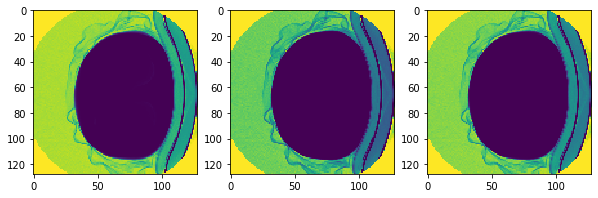

Wall time: 11min 17s


In [11]:
%%time

test = np.load("data/object1_20keV.npy")
test2 = np.load("data/object1_50keV.npy")
test3 = np.load("data/object1_100keV.npy")
# test = np.load("data/test_array.npy")
n_ph = 50000


def monteCarlo_imagingYZ(N, mu_arr, N2, N3, l):
    x, dx = np.linspace(0, l, N, retstep= True)
    im_arr = np.zeros(shape=(N3,N2))
    for i, n_step in enumerate(trange(N3), start=0):
        for j in range(N2):
            im_arr[i][j] = mainCode(x, dx, mu_arr[:, j, i], n_ph)[-1]
    return im_arr
    
def monteCarlo_imagingXY(N, mu_arr, N2, N3, l):
    x, dx = np.linspace(0, l, N2, retstep= True)
    im_arr = np.zeros(shape=(N2,N))
    for i, n_step in enumerate(trange(N2), start=0):
        for j in range(N):
            im_arr[i][j] = mainCode(x, dx, mu_arr[j, i, :], n_ph)[-1]
    return im_arr

def monteCarlo_imagingXZ(N, mu_arr, N2, N3, l):
    x, dx = np.linspace(0, l, N3, retstep= True)
    im_arr = np.zeros(shape=(N3,N))
    for i, n_step in enumerate(trange(N3), start=0):
        for j in range(N2):
            im_arr[i][j] = mainCode(x, dx, mu_arr[j, :, i], n_ph)[-1]
    return im_arr

n = len(test)
n2 = len(test[0])
n3= len(test[0][0])
#Defining the dimensions of the object
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(monteCarlo_imagingYZ(n, test, n2, n3, 6.5))
plt.subplot(1,3,2)
plt.imshow(monteCarlo_imagingYZ(n,test2,n2,n3, 44.6))
plt.subplot(1,3,3)
plt.imshow(monteCarlo_imagingYZ(n,test3,n2,n3, 44.6))
plt.show()

In this alternative method, each function creates a 2D array by itereting through the attenuation-probabilities in the x, y and z axis of an object respectively.

In [ ]:
%%time
#Creating three different functions for plotting the contours in all three dimensions

def YZ_plane(N, mu_arr, N2,N3, dx):
    im_arr = np.ones(shape=(N3,N2))
    for i in range(N3):
        for j in range(N2):
            for k in range(N):
                im_arr[i][j] *= (1-mu_arr[k, j, i]*dx)
    return im_arr

#Since the probability of the photon passing through a given dx is given by µ,
#one can use the law of total probability to determine whether the photon will
#reach the end of the object or not. By multiplying up all the probabilities given 
#by 1-p and iterating through all the matrices we obtain values for our plot 
#shown below

def XY_plane(N, mu_arr, N2,N3, dx):
    im_arr = np.ones(shape=(N2,N))
    for i in range(N2):
        for j in range(N):
            for k in range(N3):
                im_arr[i][j] *= (1-mu_arr[j, i, k]*dx)
    return im_arr

def XZ_plane(N, mu_arr, N2,N3, dx):
    im_arr = np.ones(shape=(N3,N))
    for i in range(N3):
        for j in range(N):
            for k in range(N2):
                im_arr[i][j] *= (1-mu_arr[j, k, i]*dx)
    return im_arr



In [ ]:
%%time
#Loading all necessary data and defining the dimensions

object1_20keV = np.load("data/object1_20keV.npy")
#the dimensions of object1_20keV is the same as for 50keV and 100keV
n = len(object1_20keV)
n2 = len(object1_20keV[0])
n3= len(object1_20keV[0][0])

#Creating a list of images of the object from the three different planes respectively
im_object1_20keV = [YZ_plane(n, object1_20keV, n2, n3, 6.5/(n+1)), XY_plane(n, object1_20keV, n2, n3, 44.6/(n2+1)), XZ_plane(n, object1_20keV, n2, n3, 44.6/n3+1)]

object1_50keV = np.load("data/object1_50keV.npy")
im_object1_50keV = [YZ_plane(n, object1_50keV, n2, n3, 6.5/(n+1)), XY_plane(n, object1_50keV, n2, n3, 44.6/(n2+1)), XZ_plane(n, object1_50keV, n2, n3, 44.6/(n3+1))]

object1_100keV = np.load("data/object1_100keV.npy")
im_object1_100keV = [YZ_plane(n, object1_100keV, n2, n3, 6.5/(n+1)), XY_plane(n, object1_100keV, n2, n3, 44.6/(n2+1)), XZ_plane(n, object1_100keV, n2, n3, 44.6/(n3+1))]

object2_25keV = np.load("data/object2_25keV.npy")
#overwriting the variables n, n2 and n3 is okay since they will not be used further
n = len(object2_25keV)
n2 = len(object2_25keV[0])
n3= len(object2_25keV[0][0])

im_object2_25keV = [YZ_plane(n, object2_25keV, n2, n3, 12/(n+1)), XY_plane(n, object2_25keV, n2, n3, 12/(n2+1)), XZ_plane(n, object2_25keV, n2, n3, 10/(n3+1))]

object2_50keV = np.load("data/object2_50keV.npy")
im_object2_50keV = [YZ_plane(n, object2_50keV, n2, n3, 12/(n+1)), XY_plane(n, object2_50keV, n2, n3, 12/(n2+1)),XZ_plane(n, object2_50keV, n2, n3, 10/(n3+1))]

object2_75keV = np.load("data/object2_75keV.npy")
im_object2_75keV = [YZ_plane(n, object2_75keV, n2, n3, 12/(n+1)), XY_plane(n, object2_75keV, n2, n3, 12/(n2+1)),XZ_plane(n, object2_75keV, n2, n3, 10/(n3+1))]

#Grouping all different objects, with different energy levels in six variables
#for easy plotting

In [ ]:
##Object one, iterating through the lists made above to get all perpendicular 
#directions
for i in range(3):
    plt.figure(figsize = (10,10))
    plt.subplot(1, 3, 1)
    plt.tight_layout(pad=5.0)
    plt.gca().set_title("20keV")
    plt.imshow(im_object1_20keV[i], extent=[0,45,45,0])
    plt.xlabel("y-axis [cm]")
    plt.ylabel("z-axis [cm")
    plt.subplot(1, 3, 2)
    plt.gca().set_title("50keV")
    plt.imshow(im_object1_50keV[i], extent=[0,45,45,0])
    plt.xlabel("x-axis [cm]")
    plt.ylabel("y-axis [cm")
    plt.subplot(1, 3, 3)
    plt.gca().set_title("100keV")
    plt.imshow(im_object1_100keV[i], extent=[0,45,45,0])
    plt.xlabel("x-axis [cm]")
    plt.ylabel("z-axis [cm")
    plt.show()



In [ ]:
#Object two, a coffeemug perhaps?
for i in range(3):
    plt.figure(figsize = (12,12))
    plt.subplot(1, 3, 1)
    plt.gca().set_title("20keV")
    plt.imshow(im_object2_25keV[i])
    plt.xlabel("y-axis [cm]")
    plt.ylabel("z-axis [cm")
    plt.subplot(1, 3, 2)
    plt.gca().set_title("50keV")
    plt.imshow(im_object2_50keV[i])
    plt.xlabel("x-axis [cm]")
    plt.ylabel("y-axis [cm")
    plt.subplot(1, 3, 3)
    plt.gca().set_title("75keV")
    plt.imshow(im_object2_75keV[i])
    plt.xlabel("x-axis [cm]")
    plt.ylabel("z-axis [cm")
    plt.show()

Looking at our contourplots, we can comment on a few aspects. We note the clear difference between $20$keV and $50$keV radiation. The $50$keV brings out far better contrasts and provides a much more detailed image. This is the case for both objects. However contrasts from $50$ to $75$ or $100$keV are not as apparent. In both objects we can notice a bit more contrast, but it does not provide any new information. 

We believe that object one is a set of human lungs, and if so, one should be careful to use a high dosage without a noticable contrast improvement. For this case the $50$keV image is the best choice to maintain safety and at the same time recieve the needed information. 

As for object two, which seems to be a coffeemug, the safety is not at an essence. The only consequence could be some hydrogen and oxygen gasses, but the coffee would be safe to drink. Nevertheless a higher energy dose is more expensive and, as was the case for object one, not necessary. 

### Conclusion

The Monte Carlo method provides a good visual representation of x-rays. We find the method to be simple, intuitive and, with a great number of simulations, very precise. As for downsides, it really only relies on computational capacity and parameters. Our code does not have a very long runtime, and as for parameters we need to trust them as they were given. $\mu$ is given from textfiles so we find it to be trustworthy and all other calculations seem reasonable. All in all a robust experiment. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30be234a-6605-43ec-b455-b3ae43c10302' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>